# Synthetic Data Experiments with Few Features and Complex Label Relationship


In [22]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Data Generation

Should move this elsewhere and actually store the data once it's a bit better

In [83]:
def feature_gen(n, dim, cov_min, cov_max, mean_min, mean_max, num_categories):
    """
    Generate feature data, which has one categorical feature and the rest generated as random Gaussian
    according to a random covariance matrix.
    """

    # First, generating the Gaussian data features, of which there will be dim-1

    # Cholesky decomposition of random matrix to get a valid covariance matrix
    M = np.random.uniform(cov_min, cov_max, size=(dim-1, dim-1))
    cov = M.T @ M
    mean = np.random.uniform(mean_min, mean_max, size=dim-1)
    gauss_data = np.random.multivariate_normal(mean, cov, size=n)

    # Next, generate categorical data
    cat_data = np.random.choice(np.arange(num_categories), size=n)

    # Combine
    data = np.hstack((gauss_data, cat_data[:, np.newaxis]))
    
    return data

def label_fun(xs, n_terms, term_size, coeff_min, coeff_max, max_exponent):
        """
        xs: Feature data to label
        n_terms: Number of terms in generating poliynomial
        term_size: Number of features to use in each term
        coeff_min: Min coefficient value of term
        coeff_max: Max coefficient value of term
        max_exponent: Max exponent value of each term. 

        Generates labels w polynomial relation to features, normalized to 0-1

        Note: You could, in current generating process, end up with two different terms in polynomial
        that could be simplified into one term. I don't think this is particularly important. 
        """

        # Polynomial Generation
        feature_dim = xs.shape[1]
        # pick coefficients of each polynomial term 
        coefficients = np.random.uniform(coeff_min, coeff_max, size = n_terms)
        # pick variables to include in that term
        variables = [np.random.choice(np.arange(feature_dim), size=term_size, replace=False) for i in range(n_terms)]
        # pick values in exponent for each of the variables for that term
        powers = [np.random.choice(np.arange(max_exponent+1), size=term_size) for i in range(n_terms)]
        # evaluate each term of the polynomial
        terms = np.array([coefficients[i] * np.prod(xs[:,variables[i]]**powers[i], axis=1) for i in range(n_terms)])
        labels = np.sum(terms, axis=0)

        # normalizing to 0-1
        #labels = (labels - np.min(labels))/(np.max(labels)-np.min(labels))
        #labels=np.log(labels)
        
        return labels

def label_gen(xs, label_dim, n_poly_terms, term_size, coeff_min, coeff_max, max_exponent):
    """
    Assumes that the final row of xs is categorical indicator. For each of the categories described there, uses a different generating function for the ys.

    xs: Feature data
    label_dim: Dimension of label vector; each column will be uncorrelated w others. 
    n_poly_terms: Number of terms in each generating polynomial
    term_size: Size of each polynomial term (in terms of number of features to use)
    coeff_min: Min coefficient value of term
    coeff_max: Max coefficient value of term
    max_exponent: Max exponent value of each term. 
    """
    categories = np.unique(xs[:,-1])
    labels = np.zeros((len(xs), label_dim))
    for cat in categories:
        cat_index = (xs[:,-1]==cat)
        for j in range(label_dim):
            labels[cat_index, j] = label_fun(xs[cat_index], n_poly_terms, term_size, coeff_min, coeff_max, max_exponent)
    return labels


# def correlated_label_gen(xs, ):   https://stats.stackexchange.com/questions/15011/generate-a-random-variable-with-a-defined-correlation-to-an-existing-variables
#     return None



In [84]:
n = 10
n_features = 5 
cov_min = -3
cov_max = 3
mean_min = -5
mean_max = 5
num_categories = 3

xs = feature_gen(n, n_features, cov_min, cov_max, mean_min, mean_max, num_categories)

label_dim = 3
n_terms = 3
term_size = 4
coeff_min = -1
coeff_max = 1
max_exponent = 2

ys = label_gen(xs, label_dim, n_terms, term_size, coeff_min, coeff_max, max_exponent)

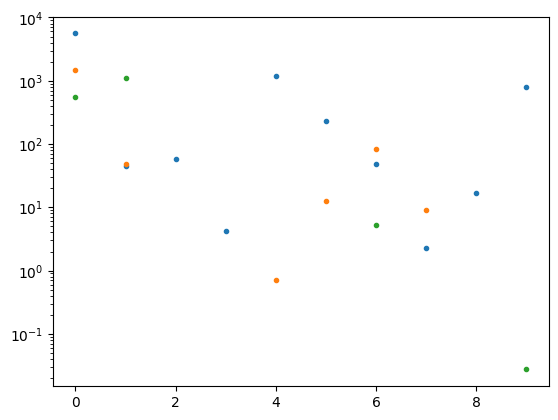

In [86]:
plt.plot(ys, '.')
plt.yscale('log')

array([[1.        , 0.13228318, 1.        ],
       [0.96010703, 0.        , 0.84894139],
       [0.41115219, 0.07343077, 0.72433539],
       [0.85994047, 1.        , 0.        ],
       [0.        , 0.6588105 , 0.82304789],
       [1.        , 0.        , 1.        ],
       [       nan,        nan,        nan],
       [0.93623649, 0.41369668, 0.61482994],
       [0.81452823, 0.25596193, 0.71642405],
       [0.        , 1.        , 0.        ]])

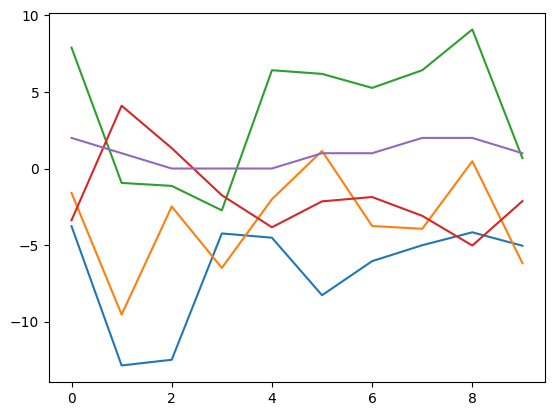

In [11]:
plt.plot(xs)

# Initial Model and Policy Generation

To generate initial models, have each run gradient boosting regression on a single coordinate and predict label mean elsewhere

In [65]:
models = []

def meta_model(coord):
    gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
    gb.fit(xs, ys[:,coord])   
    def h(xs):
            labels = np.zeros((len(xs), label_dim))
            labels[:,coord] = gb.predict(xs)
            print(coord)
            print(np.arange(label_dim)!=coord)
            other_coords = np.arange(label_dim)[np.arange(label_dim)!=coord]
            print(other_coords)
            labels[:, other_coords] = np.tile(np.mean(ys[:,other_coords], axis=0), (len(labels),1))
            return labels
    return h

for coord in range(label_dim):
    models.append(meta_model(coord))

In [66]:
models[0](xs);
models[1](xs);
models[2](xs);

0
[False  True  True]
[1 2]
1
[ True False  True]
[0 2]
2
[ True  True False]
[0 1]
